Pre-algoritmo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import networkx as nx

1. GENERACIÓN MATRIZ M

In [ ]:
# 1.1 Leer el archivo CSV sin cabecera
df = pd.read_csv('BACI_HS92_Y2010_V202501.csv', sep=',', header=0)
year = 2010

FileNotFoundError: [Errno 2] No such file or directory: 'BACI_HS92_Y2010_V202501.csv'

Contenido de BACI_HS92_Y2023_V202501.csv:

Productos en nomenclatura de 6 dígitos del Sistema Armonizado.
Flujos comerciales a nivel de año - exportador - importador - producto.

t, 1ª columna, año

i, 2ª columna, país exportador

j, 3ª columna, país importador

k, 4ª columna, producto

v, 5ª columna, volumen de producto intercambiado (toneladas métricas)

q, 6ª columna, valor monetario de la transacción (Cientos de dólares)

In [ ]:
# 1.2. Agrupar los productos, k, para quedarse con los primeros 4 dígitos.
df['k'] = df['k'].apply(lambda x: str(x)[:4])  # Convertir 'k' a string antes de aplicar el slicing

In [ ]:
# 1.3. Crear la matriz usando pivot_table para manejar entradas duplicadas
M = df.pivot_table(index='i', columns='k', values='q', aggfunc='sum')

# Reemplazar NaN por 0 en la matriz resultante
M = M.fillna(0)

# Convertir la matriz M a un DataFrame de pandas para facilitar su manipulación
M = pd.DataFrame(M, index=M.index, columns=M.columns)

Balassa‐type “Revealed Comparative Advantage” (RCA) index

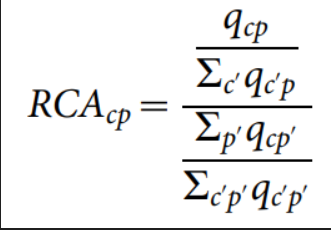

q_cp: quantity (e.g. exports) of product k by country i.

Divided by total quantity of product k across all countries.

Divided by total quantity of all products by country i.

Dividded by total quantity of all products across all countries.

El criterio del filtro no es cantidad exportada, sino valor de la cantidad exportada. Si un país regala productos, no afecta en su "economía".

In [ ]:
# 1.4. Cálculos para RCA.
# Calcula el RCA_cp para cada elemento de la matriz q y lo sustituye en M.
c, p = M.shape
M_rca = np.zeros((c, p), dtype=float)  # Inicializa la matriz RCA_cp con ceros

In [ ]:
suma_total = M.to_numpy().sum()  # Convertir M a un array NumPy para sumar
for i in range(c):
    for j in range(p):
        suma_columna = M.iloc[:, j].sum()
        suma_fila = M.iloc[i, :].sum()
        if suma_columna == 0 or suma_fila == 0:
            M_rca[i, j] = 0  # Evitar división por cero
        else:
            M_rca[i, j] = (M.iloc[i, j] / suma_columna) * (suma_total / suma_fila)

In [ ]:
# 1.5. Filtro y creación matriz binaria de M.
# M = np.zeros((c, p), dtype=int)
for i in range(c):
    for j in range(p):
        M.iloc[i, j] = np.where(M_rca[i, j] >= 1, 1, 0)

In [ ]:
# Reordenar M
# Convertir M a un DataFrame si es un array de NumPy
if isinstance(M, np.ndarray):
	M = pd.DataFrame(M)

# Ordenar las filas y columnas de M según la suma de sus valores
M = M.loc[M.sum(axis=1).sort_values(ascending=False).index, M.sum(axis=0).sort_values(ascending=False).index]

In [ ]:
# Eliminación de nodos con grado 0.
# Eliminar filas y columnas de M que sean todo 0
M = M.loc[~(M == 0).all(axis=1), ~(M == 0).all(axis=0)]

# Verificar si alguna fila o columna de M tiene todos sus valores iguales a 0
filas_todo_cero = (M == 0).all(axis=1).any()
columnas_todo_cero = (M == 0).all(axis=0).any()

if filas_todo_cero:
    print("Índice de filas con todos sus valores en 0:", M.index[(M == 0).all(axis=1)].tolist())
if columnas_todo_cero:
    print("Índice de columnas con todos sus valores en 0:", M.columns[(M == 0).all(axis=0)].tolist())

print(f"¿Alguna fila tiene todos sus valores en 0? {filas_todo_cero}")
print(f"¿Alguna columna tiene todos sus valores en 0? {columnas_todo_cero}")

¿Alguna fila tiene todos sus valores en 0? False
¿Alguna columna tiene todos sus valores en 0? False


ALGORITMO

Notación

A^{n}: Vector de la variable A en la iteración n.
Ag^{n}: Vector de la variable no normalizada A en la iteración n. (Variable intemedia de iteración).
B_c^{n}: Componente c de la variable B en la iteración n.

Declaración de variables
F: Vector de la Competitividad normalizada.
Q: Vector de la Complejidad normalizadas.
F_valores: Matriz que guarda los valores de F en cada iteración.
Q_valores: Matriz que guarda los valores de Q en cada iteración.

Consideraciones sobre las Condiciones iniciales:
Para el paso previo de calcular Fg^{n} y Qg^{n}, es necesario haber normalizado F^{n-1} y Q^{n-1}. 
Se toma A^{n} = 0 para el caso de Ag^{n-1} = 0.

Para calcular las variables intermedias Fg^{1} y Qg^{1}, se calculan primero F^{0} y Q^{0}.

In [ ]:
c,p = M.shape

#Condiciones iniciales.
Fg = np.ones(c)
Qg = np.ones(p)
# Condiciones iniciales normalizadas.
F = Fg / np.mean(Fg)
Q = Qg / np.mean(Qg)

In [ ]:
# Definimos el número de iteraciones.
n = 80
# Definir la transpuesta de la matriz M
M_T = M.T

# Generamos la matriz que va a guardar los valores.
F_valores = np.zeros((n, c))
Q_valores = np.zeros((n, p))

for i in range(n):
    # 1) Cálculo de las variables intermedias:
    # Cálculo paso a paso de los productos matriciales.
    invF = np.zeros(c) # Inicializamos el vector invF[c] = 0
    for c_idx in range(c):
    # 1.1) Cálculo de Fg en la iteración n:
        Fg[c_idx] = np.sum(M.iloc[c_idx, :] * Q)
    # 1.2) Cálculo de Qg en la iteración n:
        # invF[c_idx] = 1.0 / F[c_idx] # donde invF[c] = 1 / F[c]
        if F[c_idx] == 0:
            invF[c_idx] = 0
        else:
            invF[c_idx] = 1.0 / F[c_idx]
    invQ = np.zeros(p) # Inicializamos el vector invQ[p] = 0
    for p_idx in range(p):
        invQ[p_idx] = np.sum(M_T.iloc[p_idx, :] * invF) # Fg[p] = \sum_c M_{c,p} * (1/F[c])
        if invQ[p_idx] == 0:
            Qg[p_idx] = 0
        else:
            Qg[p_idx] = 1.0 / invQ[p_idx]
    
    # # (No se queda este párrafo)
    # # Cálculos sin hacer paso a paso los productos matriciales.
    # Fg = np.dot(M, Q) # donde Fg[c] = \sum_p M_{c,p} * Q[p]
    # invF = 1.0 / F # donde invF[c] = 1 / F[c]
    # invQ = np.dot(M.T, invF) # donde Qg[p] = \sum_c M_{c,p} * (1/F[c])
    # Qg = 1.0 / invQ # np.where(invQ != 0, 1.0 / invQ, 0) # donde Qg[p] = 1 / \sum_c ( M_{c,p} / F_c^{(n-1)} )

    # 3) Normalización de y actualización de F y Q para la siguiente iteración.
    F = Fg / np.mean(Fg)
    Q = Qg / np.mean(Qg)

    # 4) Guardar los valores de F y Q en cada iteración para su posterior análisis/representación.
    F_valores[i, :] = F
    Q_valores[i, :] = Q

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8728\1307773577.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


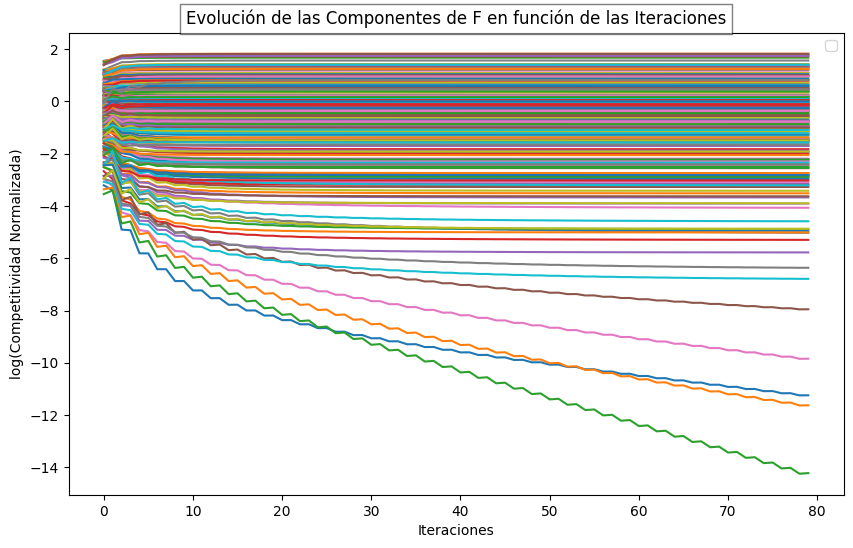

In [ ]:
# Representar la evolución de las componentes de F en función de las iteraciones
plt.figure(figsize=(10, 6))
logaritmo = 1 # Cambiar a 0 para escala lineal
if logaritmo == 1: # Representación en escala logarítmica.
    for j in range(c):
        plt.plot(range(n), np.log(F_valores[:, j]))
    plt.ylabel('log(Competitividad Normalizada)')
else:
    for j in range(c):
        plt.plot(range(n), F_valores[:, j])
    plt.ylabel('Competitividad Normalizada')

plt.xlabel('Iteraciones')
plt.title('Evolución de las Componentes de F en función de las Iteraciones', bbox=dict(facecolor="white", alpha=0.5))
plt.legend()
plt.show()

Representación de la red compleja.

In [ ]:
# Extraer las filas de M correspondientes a los 10 primeros valores de F
top_10_indices = np.argsort(F)[-10:]  # Obtener los índices de los 10 valores más altos de F
M_top_10 = M.iloc[top_10_indices, :]  # Extraer las filas correspondientes de M

# Crear una matriz con los valores de M_top_10 y sólo las 10 primeras columnas
mM = np.array(M_top_10.iloc[:, :10])

In [ ]:
# Crea un grafo no dirigido
G = nx.Graph()

# Nombres de los 10 primeros países
countries = [str(x) for x in list(M.index[:10])]
# Nombres de los 10 primeros productos
products = list(M.columns[:10])

In [ ]:
# Leer el archivo country_codes_V202501 y crear un diccionario para el mapeo
country_codes = {}
with open('country_codes_V202501.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        country_codes[row[0]] = row[1]
# Reemplazar los códigos por los nombres.
# Sustituir cada elemento de countries por el valor de la segunda columna evitando países vacíos
countries = [country_codes.get(country, country) for country in countries]

# Invertir el orden de los elementos de countries
countries.reverse()

In [ ]:
# Leer el archivo product_codes_HS92_V202501 y crear un diccionario para el mapeo
product_codes = {}
with open('product_codes_HS92_V202501.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        # Verificar que la fila tiene al menos dos columnas y que la segunda columna contiene un ':'
        if len(row) > 1 and ':' in row[1]:
            if any(str(product).startswith(row[0][:4]) for product in products):
                product_codes[row[0]] = row[1].split(':')[0].strip()  # Obtener solo las primeras palabras antes de ':' y eliminar espacios en blanco
# Sustituir cada elemento de products por las primeras palabras del contenido del elemento correspondiente a la segunda columna
products = [product_codes.get(product, product) for product in products]

# Invertir el orden de los elementos de products
products.reverse()
print(products)

['7802', '3917', '1211', '1905', '8507', '2202', '7404', '3923', '7602', '7204']


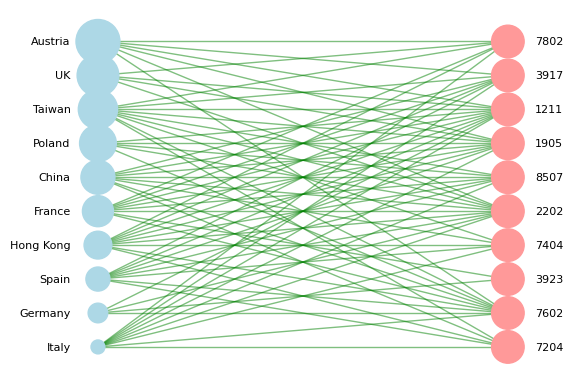

In [ ]:
# Añade los nodos (países y códigos) al grafo
for country in countries:
    G.add_node(country)
for product in products:
    G.add_node(product)

# Añade las aristas al grafo basado en la matriz de adyacencia
for i in range(len(countries)):
    for j in range(len(products)):
        if mM[i][j] == 1:
            G.add_edge(countries[i], products[j])

# Colores para los nodos (puedes ajustar esto según tus preferencias)
node_colors = ['#ADD8E6'] * len(countries) + ['#FF9999'] * len(products)

# Tamaño de los nodos
node_sizes = [1000 - 100 * i if node in countries else 1000 - 50 * j for i, node in enumerate(G.nodes())]

# Posicionamiento de los nodos con mayor separación vertical
pos = {}
x_offset = -1  # Offset para la columna de países
y_spacing = 1.5  # Espaciado vertical entre nodos

# Posicionar los nodos de countries con mayor espaciado
for idx, country in enumerate(countries):
    pos[country] = (x_offset, -idx * (y_spacing + 10))

x_offset = 2  # Offset para la columna de productos

# Posicionar los nodos de products
for idx, product in enumerate(products):
    pos[product] = (x_offset, -idx * (y_spacing + 10))

# Dibuja el grafo
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='green', alpha=0.5)
# Dibujar etiquetas a los lados de los nodos
for node, (x, y) in pos.items():
    if node in countries:
        plt.text(x - 0.2, y, node, fontsize=8, ha='right', va='center')  # Etiquetas más cerca a la izquierda de los países
    else:
        plt.text(x + 0.2, y, node, fontsize=8, ha='left', va='center')  # Etiquetas más cerca a la derecha de los productos

# Ajustar los límites del gráfico
plt.axis('off')
plt.show()